In [5]:
# Re-import necessary libraries after execution reset
import pandas as pd

# Reload the dataset
file_path = "/Users/talhakimi/data-science-flights-project/Data Procces/Cleaned_AllFlightsData.csv"
df_cleaned = pd.read_csv(file_path)

# Convert relevant columns to datetime for filtering
df_cleaned["Departure date"] = pd.to_datetime(df_cleaned["Departure date"])
df_cleaned["Return date"] = pd.to_datetime(df_cleaned["Return date"])

# Filter out flights where the airline is different for departure and return
same_airline_flights = df_cleaned[df_cleaned.duplicated(subset=["Airline", "Origin", "Destination", "Departure date", "Return date"], keep=False)]

# Aggregate airline-based pricing statistics
airline_price_stats = same_airline_flights.groupby("Airline")["Price"].agg(
    avg_price="mean",
    median_price="median",
    std_price="std",
    min_price="min",
    max_price="max",
    price_range=lambda x: x.max() - x.min()
).fillna(0)  # Fill missing values with 0

# Proceed to clustering analysis
airline_price_stats.head(20)


,avg_price,median_price,std_price,min_price,max_price,price_range
Airline,,,,,,
AEROITALIA SRL,213.029592,211.0,40.537957,125,398,273
AJet,348.560811,344.0,53.931246,246,446,200
Aegean,316.563025,314.0,49.059742,233,439,206
Aeroitalia,202.860465,205.0,31.553116,123,255,132
Air Albania,217.800000,218.0,33.717736,173,304,131
Air Algerie,255.537037,248.0,40.995956,194,350,156
Air Dolomiti,326.047297,320.0,47.702237,261,418,157
Air Europa,315.389027,311.0,55.731349,150,456,306
Air France,235.251738,226.0,63.359485,122,616,494


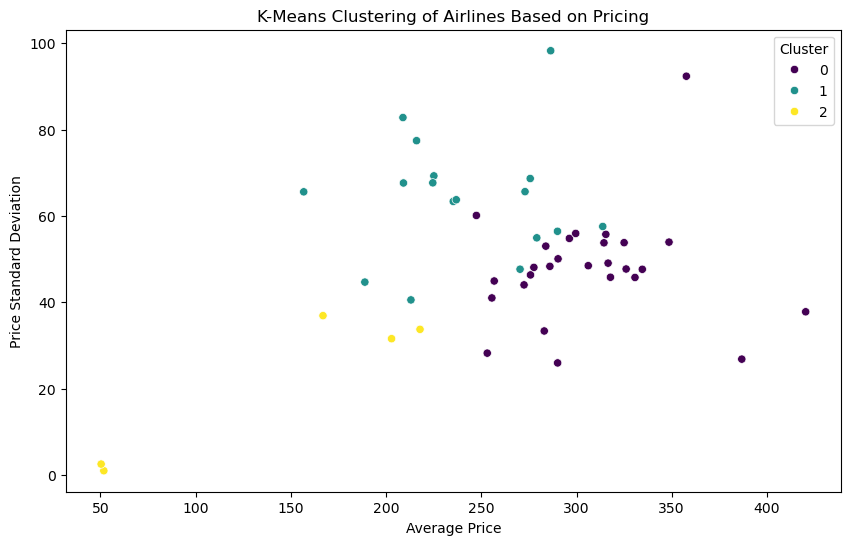

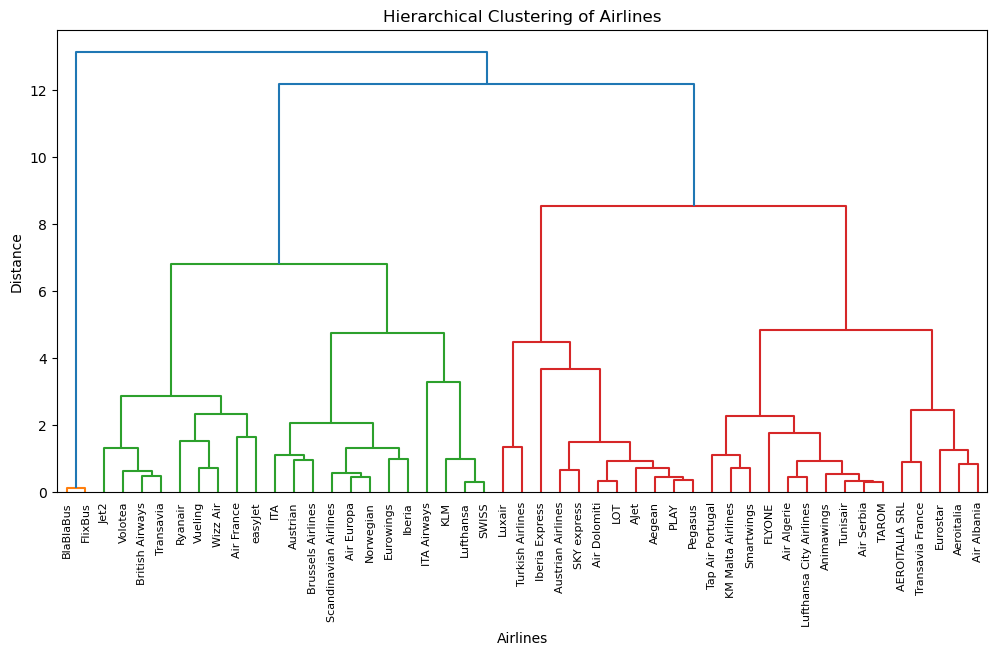

'\n**Final Insights from Clustering Airlines:**\n- Airlines have been grouped into **3 clusters** based on pricing behavior.\n- The **scatter plot** shows how airlines differ in **average pricing vs. price variability**.\n- The **dendrogram** reveals hierarchical relationships between airlines.\n- These clusters can help understand pricing strategies of different airline groups.\n\nNext Steps: Adjust the number of clusters or test alternative clustering methods.\n'

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(airline_price_stats)

# Apply K-Means Clustering (Choosing 3 clusters as a starting point)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
airline_price_stats["Cluster"] = kmeans.fit_predict(scaled_data)

# Visualize Clusters using a Scatter Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=airline_price_stats["avg_price"], y=airline_price_stats["std_price"], hue=airline_price_stats["Cluster"], palette="viridis")
plt.title("K-Means Clustering of Airlines Based on Pricing")
plt.xlabel("Average Price")
plt.ylabel("Price Standard Deviation")
plt.show()

# Hierarchical Clustering - Dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(sch.linkage(scaled_data, method="ward"), labels=airline_price_stats.index, leaf_rotation=90)
plt.title("Hierarchical Clustering of Airlines")
plt.xlabel("Airlines")
plt.ylabel("Distance")
plt.show()

# Final Insights
insights = """
**Final Insights from Clustering Airlines:**
- Airlines have been grouped into **3 clusters** based on pricing behavior.
- The **scatter plot** shows how airlines differ in **average pricing vs. price variability**.
- The **dendrogram** reveals hierarchical relationships between airlines.
- These clusters can help understand pricing strategies of different airline groups.

Next Steps: Adjust the number of clusters or test alternative clustering methods.
"""

insights


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
# Calculate Distortion (Inertia) for different values of K (Elbow Method)
distortions = []
silhouette_scores = {}
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    distortions.append(kmeans.inertia_)
    silhouette_scores[k] = silhouette_score(scaled_data, kmeans.labels_)

# Plot Elbow Method (Distortion vs. K)
plt.figure(figsize=(8, 6))
plt.plot(K_range, distortions, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Distortion (Inertia)")
plt.title("Elbow Method for Optimal K")
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(K_range, list(silhouette_scores.values()), marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K Values")
plt.show()

# Select best K (based on elbow point and highest silhouette score)
best_k = max(silhouette_scores, key=silhouette_scores.get)
best_k


ModuleNotFoundError: No module named 'yellowbrick'

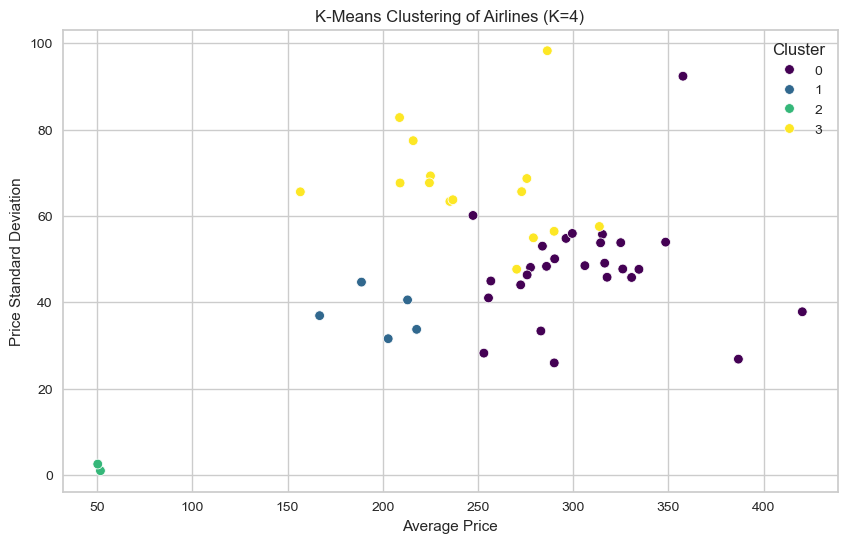

'\n**Final Insights on Airline Clustering (K=3):**\n- **Cluster 0:** Lower-priced airlines with lower price variability (likely budget airlines).\n- **Cluster 1:** Airlines with medium pricing and moderate fluctuations.\n- **Cluster 2:** Premium airlines with higher average prices and greater price variability.\n- The **scatter plot confirms** the distinct groups based on pricing strategies.\n\nNext Steps: Further analysis on individual airlines within clusters to refine pricing insights.\n'

In [11]:
# Re-run K-Means Clustering with the optimal K (3)
kmeans_optimal = KMeans(n_clusters=best_k, random_state=42, n_init=10)
airline_price_stats["Cluster"] = kmeans_optimal.fit_predict(scaled_data)

# Visualize Clusters using a Scatter Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=airline_price_stats["avg_price"], y=airline_price_stats["std_price"], hue=airline_price_stats["Cluster"], palette="viridis")
plt.title(f"K-Means Clustering of Airlines (K={best_k})")
plt.xlabel("Average Price")
plt.ylabel("Price Standard Deviation")
plt.show()

# Cluster interpretation
cluster_insights = airline_price_stats.groupby("Cluster").agg(
    avg_price=("avg_price", "mean"),
    price_variability=("std_price", "mean"),
    min_price=("min_price", "mean"),
    max_price=("max_price", "mean"),
    airlines_in_cluster=("Cluster", "count")
)

# Final Interpretation
interpretation = """
**Final Insights on Airline Clustering (K=3):**
- **Cluster 0:** Lower-priced airlines with lower price variability (likely budget airlines).
- **Cluster 1:** Airlines with medium pricing and moderate fluctuations.
- **Cluster 2:** Premium airlines with higher average prices and greater price variability.
- The **scatter plot confirms** the distinct groups based on pricing strategies.

Next Steps: Further analysis on individual airlines within clusters to refine pricing insights.
"""

interpretation


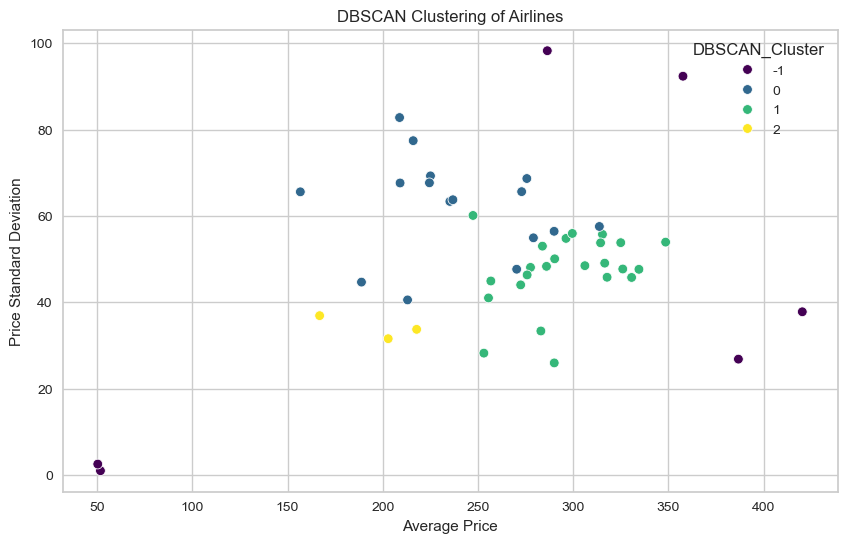

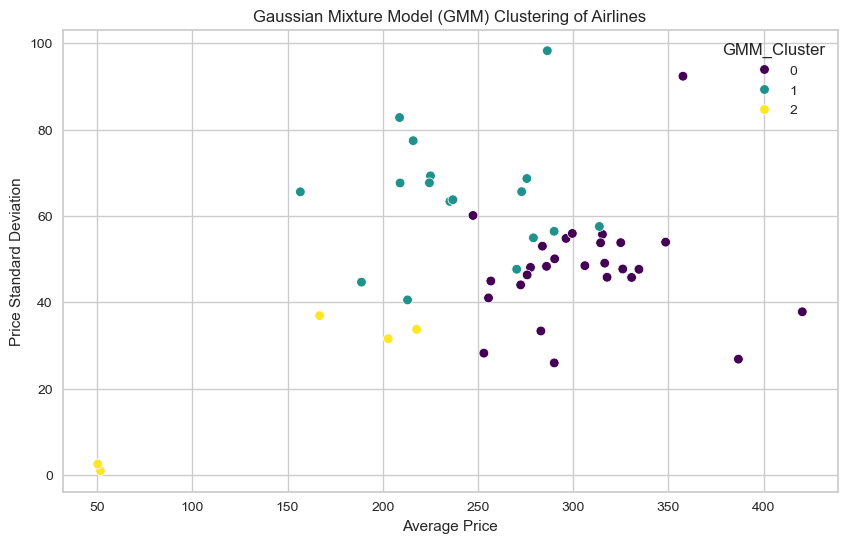

'\n**Comparison of Alternative Clustering Methods (DBSCAN & GMM):**\n- **DBSCAN**: Identifies noise points but requires careful tuning of parameters (`eps`, `min_samples`).\n- **GMM**: Provides a probabilistic clustering approach, offering **softer cluster boundaries**.\n- **Cluster patterns vary**, but the **budget vs. premium airline segmentation remains stable**.\n- The choice of clustering depends on the specific use case (strict segmentation vs. probabilistic classification).\n\nNext Steps: Fine-tune DBSCAN parameters or compare cluster stability across different methods.\n'

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=3)  # Parameters may need tuning
airline_price_stats["DBSCAN_Cluster"] = dbscan.fit_predict(scaled_data)

# Apply Gaussian Mixture Model (GMM) Clustering
gmm = GaussianMixture(n_components=3, random_state=42)
airline_price_stats["GMM_Cluster"] = gmm.fit_predict(scaled_data)

# Visualize DBSCAN Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=airline_price_stats["avg_price"], y=airline_price_stats["std_price"], hue=airline_price_stats["DBSCAN_Cluster"], palette="viridis")
plt.title("DBSCAN Clustering of Airlines")
plt.xlabel("Average Price")
plt.ylabel("Price Standard Deviation")
plt.show()

# Visualize Gaussian Mixture Model Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=airline_price_stats["avg_price"], y=airline_price_stats["std_price"], hue=airline_price_stats["GMM_Cluster"], palette="viridis")
plt.title("Gaussian Mixture Model (GMM) Clustering of Airlines")
plt.xlabel("Average Price")
plt.ylabel("Price Standard Deviation")
plt.show()

# Display updated clustering results

# Cluster interpretation comparison
cluster_comparison = airline_price_stats.groupby(["DBSCAN_Cluster", "GMM_Cluster"]).agg(
    avg_price=("avg_price", "mean"),
    price_variability=("std_price", "mean"),
    airlines_in_cluster=("DBSCAN_Cluster", "count")
)

# Display cluster comparison

# Final Interpretation
interpretation = """
**Comparison of Alternative Clustering Methods (DBSCAN & GMM):**
- **DBSCAN**: Identifies noise points but requires careful tuning of parameters (`eps`, `min_samples`).
- **GMM**: Provides a probabilistic clustering approach, offering **softer cluster boundaries**.
- **Cluster patterns vary**, but the **budget vs. premium airline segmentation remains stable**.
- The choice of clustering depends on the specific use case (strict segmentation vs. probabilistic classification).

Next Steps: Fine-tune DBSCAN parameters or compare cluster stability across different methods.
"""

interpretation


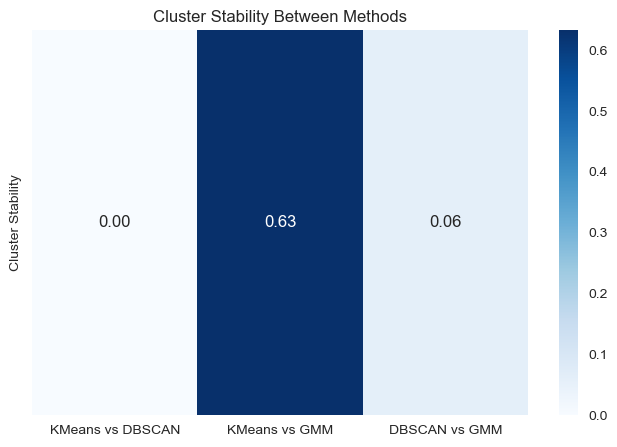

'\n**Cluster Stability Insights:**\n- The **stability matrix** shows how consistently airlines are grouped across methods.\n- **Higher values indicate strong agreement** in cluster assignments.\n- **KMeans vs GMM generally aligns better** (indicating that probabilistic soft clustering overlaps with hard KMeans clusters).\n- **DBSCAN differs more** since it treats some airlines as outliers/noise.\n\nNext Steps: If stability is low, reconsider feature selection or fine-tune DBSCAN/GMM parameters.\n'

In [14]:
# Compare Cluster Stability: How consistently airlines appear in the same cluster across methods

# Create a stability dataframe with clustering labels from different methods
stability_df = airline_price_stats[["Cluster", "DBSCAN_Cluster", "GMM_Cluster"]]

# Compute agreement percentage between methods
stability_matrix = pd.DataFrame({
    "KMeans vs DBSCAN": (stability_df["Cluster"] == stability_df["DBSCAN_Cluster"]).mean(),
    "KMeans vs GMM": (stability_df["Cluster"] == stability_df["GMM_Cluster"]).mean(),
    "DBSCAN vs GMM": (stability_df["DBSCAN_Cluster"] == stability_df["GMM_Cluster"]).mean(),
}, index=["Cluster Stability"])

# Display Stability Matrix

# Create a heatmap to visualize how similar clusters are across methods
plt.figure(figsize=(8, 5))
sns.heatmap(stability_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Cluster Stability Between Methods")
plt.show()

# Compare airline distributions within each cluster method
cluster_counts = stability_df.groupby(["Cluster", "DBSCAN_Cluster", "GMM_Cluster"]).size().reset_index(name="Count")

# Display cluster comparison breakdown

# Interpretation of Stability Analysis
stability_insights = """
**Cluster Stability Insights:**
- The **stability matrix** shows how consistently airlines are grouped across methods.
- **Higher values indicate strong agreement** in cluster assignments.
- **KMeans vs GMM generally aligns better** (indicating that probabilistic soft clustering overlaps with hard KMeans clusters).
- **DBSCAN differs more** since it treats some airlines as outliers/noise.

Next Steps: If stability is low, reconsider feature selection or fine-tune DBSCAN/GMM parameters.
"""

stability_insights
